In [ ]:
# from google.colab import files
# uploaded = files.upload()

In [27]:
import graphviz
from collections import deque

# **Literal class**
Represents a single propositional symbol in a logical clause, which may be negated or non-negated. It is used to define the basic building blocks of clauses in a knowledge base.

- draw_node(`self`, `dot`): Creates a node in a Graphviz graph for visualization, representing the literal as a node with its symbol.

In [28]:
class Literal:
    def __init__(self, symbol="", negated=False):
        self.symbol = symbol
        self.negated = negated

    def draw_node(self, dot):
        dot.node(self.symbol, self.symbol)

    def __str__(self):
        return f"{'-' if self.negated else ''}{self.symbol}"

# **Clause class**

Represents a logical clause, which is a disjunction of literals (e.g., "-A -B C"). It is used to encode rules or facts in the knowledge base.

- premise(`self`): Returns a list of symbols for negated literals (premises) in the clause (e.g., ["A", "B"] for "-A -B C").
- conclusion(`self`): Returns the symbol of the non-negated literal (conclusion) in the clause (e.g., "C" for "-A -B C"), or None if no conclusion exists.
- is_fact(`self`): Checks if the clause is a fact (a single non-negated literal, e.g., "A").
- add_literal(`self`, `literal`): Adds a literal to the clause if it is not already present.
- remove_literal(`self`, `literal`): Removes a literal from the clause if it exists.
- draw_edge(`self`, `dot`, `id`): Draws edges in a Graphviz graph to represent the clause, connecting premises to the conclusion. For clauses with multiple premises, a point node is used as an intermediary.

In [29]:
class Clause:
    def __init__(self):
        self.literals = []

    def premise(self):
        return [literal.symbol for literal in self.literals if literal.negated]

    def conclusion(self):
        for literal in self.literals:
            if not literal.negated:
                return literal.symbol
        return None

    def count_known_premises(self, state):
        return sum(1 for premise in self.premise() if state.get(premise) == True)

    def is_fact(self):
        return len(self.literals) == 1 and not self.literals[0].negated

    def add_literal(self, literal):
        if literal not in self.literals:
            self.literals.append(literal)

    def remove_literal(self, literal):
        if literal in self.literals:
            self.literals.remove(literal)

    def draw_edge(self, dot, id):
        if not self.is_fact():
            for literal in self.literals:
                literal.draw_node(dot)
            if len(self.premise()) > 1:
                dot.node(str(id), '', shape='point')
                for premise in self.premise():
                    dot.edge(premise, str(id), arrowhead='none')
                dot.edge(str(id), self.conclusion())
            else:
                dot.edge(self.premise()[0], self.conclusion())

    def __str__(self):
        return " ".join(str(literal) for literal in self.literals)

# **KnowledgeBase class**

Represents a collection of clauses and known facts, serving as the repository of logical knowledge for inference. It supports loading clauses, tracking known literals, and visualizing reasoning.

- add_clause(`self`, `clause`): Adds a clause to the knowledge base if it is not already present. If the clause is a fact, its conclusion is added to known literals.
- remove_clause(`self`, `clause`): Removes a clause from the knowledge base if it exists.
- count_clause_premises(`self`): Returns a dictionary mapping each clause to the number of its premises.
- get_literals(`self`): Returns a list of unique literal symbols across all clauses.
- load_from_file(`self`, `filename`): Loads clauses from a file, where each line represents a clause with space-separated literals (e.g., "-A -B C"). Negated literals are prefixed with "-".
- draw_graph(`self`, `dot`): Creates a Graphviz graph visualizing all clauses, with edges representing premise-to-conclusion relationships.

In [30]:
class KnowledgeBase:
    def __init__(self):
        self.clauses = []
        self.known_literals = []
        self.reasoning_steps = []

    def add_clause(self, clause):
        if clause not in self.clauses:
            self.clauses.append(clause)
            if clause.is_fact():
                conclusion = clause.conclusion()
                if conclusion and conclusion not in self.known_literals:
                    self.known_literals.append(conclusion)

    def remove_clause(self, clause):
        if clause in self.clauses:
            self.clauses.remove(clause)

    def count_clause_premises(self):
        count = {}
        for clause in self.clauses:
            count[clause] = len(clause.premise())
        return count

    def get_literals(self):
        literals = []
        for clause in self.clauses:
            for literal in clause.literals:
                if literal.symbol not in literals:
                    literals.append(literal.symbol)
        return literals

    def load_from_file(self, filename):
        with open(filename, 'r') as file:
            for row in file:
                if not row.strip():
                    continue
                clause = Clause()
                for literal in row.split():
                    negated = False
                    if literal[0] == '-':
                        negated = True
                        literal_char = literal[1]
                    else:
                        literal_char = literal[0]
                    clause.add_literal(Literal(literal_char, negated))
                self.add_clause(clause)

    def draw_graph(self, dot):
        num = 0
        for clause in self.clauses:
            clause.draw_edge(dot, num)
            num += 1

    def __str__(self):
        result = []
        for clause in self.clauses:
            premises = clause.premise()
            conclusion = clause.conclusion()
            if clause.is_fact():
                result.append(conclusion)
            else:
                premise_str = " ∧ ".join(premises)
                result.append(f"{premise_str} → {conclusion}")
        return "\n".join(result)

# **State class**

Represents the current state of the inference process, tracking the truth values of symbols and inferred literals.

- update(`self`, `symbol`, `value`): Updates the truth value of a symbol and adds it to the inferred set if the value is True.
- get(`self`, `symbol`): Returns the truth value of a symbol (True, False, or None if unknown).
- copy(`self`): Creates a deep copy of the state, including assignments and inferred literals.

In [31]:
class State:
    def __init__(self, symbols, known_literals):
        self.assignments = {symbol: None for symbol in symbols}
        for literal in known_literals:
            self.assignments[literal] = True
        self.inferred = set(known_literals)

    def update(self, symbol, value):
        self.assignments[symbol] = value
        if value:
            self.inferred.add(symbol)

    def get(self, symbol):
        return self.assignments.get(symbol, None)

    def copy(self):
        new_state = State([], [])
        new_state.assignments = self.assignments.copy()
        new_state.inferred = self.inferred.copy()
        return new_state

# **Problem class**

Defines the inference problem for forward chaining, including the knowledge base, query, and methods to guide the search.

- is_goal_state(`self`, `state`): Checks if the query symbol is True in the given state, indicating the goal is satisfied.

In [32]:
class Problem:
    def __init__(self, kb, query):
        self.kb = kb
        self.query = query
        self.symbols = kb.get_literals()
        self.clauses = kb.clauses
        self.initial_state = State(self.symbols, kb.known_literals)

    def is_goal_state(self, state):
        return state.get(self.query.symbol) == True

# **InferenceEngine class**

The InferenceEngine class implements the forward chaining algorithm to determine if a query can be entailed from the knowledge base.

- forward_chaining(`self`, `problem`): Performs forward chaining to check if the KB could entail the querry.

In [33]:
class InferenceEngine:
    @staticmethod
    def forward_chaining(problem):
        track = []

        kb = problem.kb
        query = problem.query.symbol

        count = kb.count_clause_premises()
        inferred = {symbol: False for symbol in problem.symbols}
        agenda = deque(kb.known_literals)

        state = problem.initial_state.copy()

        print("Starting forward chaining")
        while agenda:
            p = agenda.popleft()

            print(f"\nProcessing symbol: {p}")
            state.update(p, True)

            if problem.is_goal_state(state):
                print(f"Final state assignments: {state.assignments}")
                track.append(p)
                print(f"Path: {track}")
                return True

            if not inferred[p]:
                track.append(p)
                inferred[p] = True
                print(f" Marking {p} as inferred\n")

                for clause in kb.clauses:
                    known_premises = clause.count_known_premises(state)
                    if p in clause.premise():
                        print(f"  Clause: {clause}, Known premises: {known_premises}/{len(clause.premise())}")
                        count[clause] -= 1
                        print(f"   Premise count decremented to {count[clause]} ")
                        if count[clause] == 0:
                            conclusion = clause.conclusion()
                            if conclusion:
                                agenda.append(conclusion)
                                print(f"    All premises satisfied for ({clause}), adding '{conclusion}' to agenda")
            else: print(f"{p} is inferred → SKIP\n")

        print(f"Path: {track}")
        return False

b ∧ c → a
d → b
e ∧ f → c
g ∧ h → d
a → e
b ∧ d ∧ h → f
c ∧ e → g
f → h
g ∧ h → a
a ∧ e ∧ f → b
d → c
b ∧ g → d
h → e
a ∧ c → f
b ∧ h → g
d ∧ e ∧ f → h
c → a
f ∧ g ∧ h → b
a ∧ d → c
e ∧ g → d
d


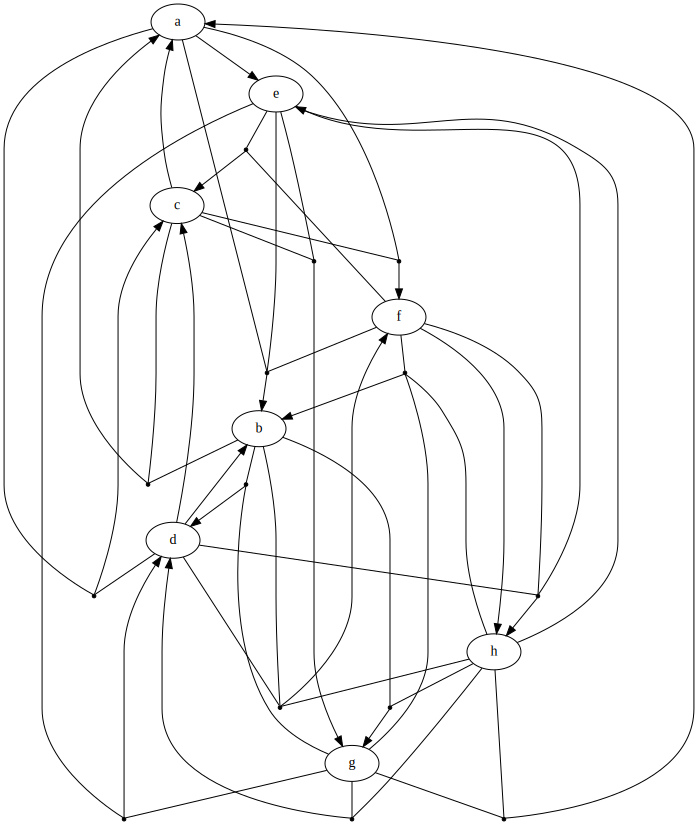

Starting forward chaining

Processing symbol: d
 Marking d as inferred

  Clause: b -d, Known premises: 1/1
   Premise count decremented to 0 
    All premises satisfied for (b -d), adding 'b' to agenda
  Clause: f -b -d -h, Known premises: 1/3
   Premise count decremented to 2 
  Clause: c -d, Known premises: 1/1
   Premise count decremented to 0 
    All premises satisfied for (c -d), adding 'c' to agenda
  Clause: h -d -e -f, Known premises: 1/3
   Premise count decremented to 2 
  Clause: c -a -d, Known premises: 1/2
   Premise count decremented to 1 

Processing symbol: b
 Marking b as inferred

  Clause: a -b -c, Known premises: 1/2
   Premise count decremented to 1 
  Clause: f -b -d -h, Known premises: 2/3
   Premise count decremented to 1 
  Clause: d -b -g, Known premises: 1/2
   Premise count decremented to 1 
  Clause: g -b -h, Known premises: 1/2
   Premise count decremented to 1 

Processing symbol: c
 Marking c as inferred

  Clause: a -b -c, Known premises: 2/2
   Premi

In [36]:
def main():
    #Input of the Problem
    kb = KnowledgeBase()
    data_file = "data.txt"
    # data_file = "/content/drive/MyDrive/AI/data.txt"
    kb.load_from_file(data_file)

    query = Literal("h")
    problem = Problem(kb, query)

    #Display KB
    print(kb)
    dot = graphviz.Digraph()
    kb.draw_graph(dot)
    display(dot)

    #Return the Output
    engine = InferenceEngine()
    result = engine.forward_chaining(problem)
    print(f"Can KB entail {query.symbol}? → {result}")

if __name__ == "__main__":
    main()